In [1]:
import pandas as pd
import numpy as np
import pymysql 
import os
import glob
from fuzzywuzzy import process
import json
import datetime
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import xgboost as xgb
from tpot import TPOTRegressor
%matplotlib inline
pd.set_option('display.max_columns', 100)

/home/valesco/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/valesco/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [18]:
os.chdir('/home/valesco/Datasets/PGA_Data/pga_master_files/')
tournament_ids = pd.read_csv('tournament_ids.csv', sep = ';')
player_results = pd.read_csv('/home/valesco/Datasets/PGA_Data/pga_master_files/player_ranks.csv', sep = ';')
tourny_ls = tournament_ids['tournament_name'].values
player_info = pd.read_csv('/home/valesco/Datasets/PGA_Data/pga_master_files/player_info.csv', sep = ',')
player_ids = pd.read_csv('/home/valesco/Datasets/PGA_Data/pga_master_files/player_ids.csv', sep = ';')
owgr_ranks = pd.read_csv('/home/valesco/Datasets/PGA_Data/pga_master_files/owgr_final.csv', sep = ';')
owgr_ranks['player_id'] = owgr_ranks['player_id'].apply(lambda x: int(x))

In [70]:
def fuzz_match(x):
    matched = process.extractOne(x, player_names)
    if matched[1] > 89:
        return player_ids['player_id'].loc[player_ids['player_name'] == matched[0]].values[0]
    else:
        return np.nan
    

rbc_df = pd.read_csv('/home/valesco/Datasets/PGA_Data/pga_temp/rbc_heritage_salaries.csv',
                          sep = ';')

player_names = player_ids['player_name'].unique()
rbc_player_names = rbc_df['player_name'].unique()
pid_dict = {}
for player in rbc_player_names:
    pid_dict[player] = fuzz_match(player)
    

rbc_df['player_id'] = rbc_df['player_name'].apply(lambda x: pid_dict[x])


rbc_df

,player_name,salary,tournament_name,tournament_id,buyin,player_id
0,Matt Kuchar,11500,RBC Heritage,12,3,23108.0
1,Russell Henley,10700,RBC Heritage,12,3,34098.0
2,Brandt Snedeker,10500,RBC Heritage,12,3,27649.0
3,Branden Grace,10000,RBC Heritage,12,3,29974.0
4,Kevin Kisner,9700,RBC Heritage,12,3,29478.0
5,Martin Kaymer,9500,RBC Heritage,12,3,27408.0
6,Tyrrell Hatton,9300,RBC Heritage,12,3,34363.0
7,Bill Haas,9100,RBC Heritage,12,3,24924.0
8,Adam Hadwin,8800,RBC Heritage,12,3,33399.0
9,Charley Hoffman,8700,RBC Heritage,12,3,12716.0


In [71]:
def prev_appear(df):
    player_id = df['player_id']
    tournament_id = df['tournament_id']
    date_cutoff = pd.to_datetime(df['date'])
    temp_df = player_results.loc[(player_results['player_id'] == player_id) & 
                                 (player_results['tournament_id'] == tournament_id) &
                                 (pd.to_datetime(player_results['tournament_start_date']) < date_cutoff)]

    num_appear = temp_df.shape[0]
    
    tourny_win = 0
    tourny_cuts_made = 0
    tourny_top_10 = 0
    
    for i in range(10):
        try:
            globals()['appear_' + str(i)] = temp_df['final_rank'].iloc[i]
        except:
            globals()['appear_' + str(i)] = -999
        
        try:
            if temp_df['final_rank'].iloc[i] == 1:
                tourny_win += 1

            if temp_df['final_rank'].iloc[i] > 0 and temp_df['final_rank'].iloc[i] < 21:
                tourny_top_10 += 1

            if temp_df['num_rounds_played'].iloc[i] == 4:
                tourny_cuts_made += 1
        except:
            pass
            
    try:        
        tourny_cut_percent = tourny_cuts_made / num_appear
        tourny_top_20_percent = tourny_top_10 / num_appear
    except:
        tourny_cut_percent = -999
        tourny_top_20_percent = -999
        
    
    return(num_appear, tourny_win, tourny_cut_percent, tourny_top_20_percent, appear_0, appear_1, 
          appear_2, appear_3, appear_4, appear_5, appear_6, appear_7, appear_8, appear_9)

def recent_results(df):
    try:
        player_id = df['player_id']
        date_cutoff = pd.to_datetime(df['date'])
        temp_df = player_results.loc[(player_results['player_id'] == player_id) & 
                                     (pd.to_datetime(player_results['tournament_start_date']) < date_cutoff)]

        temp_df.sort_values(by = 'tournament_start_date', ascending = False, inplace = True)
        
        recent_wins = 0
        
        for i in range(52):
            if i < 10: 
                try:
                    globals()['results_' + str(i)] = temp_df['final_rank'].iloc[i]
                except:
                    globals()['results_' + str(i)] = -999
            try:
                if temp_df['final_rank'].iloc[i] == 1:
                    recent_wins += 1
            except:
                pass

        return(recent_wins, results_0, results_1, results_2, results_3, results_4, results_5, results_6, 
              results_7, results_8, results_9)
    except:
        return(-999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999)
    
def recent_ownership(df):
    try:
        player_id = df['player_id']
        cutoff_date = pd.to_datetime(df['date'])
        temp_df = combo_df.loc[(combo_df['player_id'] == player_id) & (pd.to_datetime(combo_df['date']) < cutoff_date)]
        temp_df['date'] = pd.to_datetime(temp_df['date'])
        temp_df.sort_values(by = 'date', ascending = False, inplace = True)
        
        for i in range(10):
            try:
                globals()['own_' + str(i)] = temp_df['ownership'].iloc[i]
            except:
                globals()['own_' + str(i)] = -999
                
        return (own_0, own_1, own_2, own_3, own_4, own_5, own_6, own_7, own_8, own_9)
    except:
        return (-999, -999, -999, -999, -999, -999, -999, -999, -999, -999)
    
def map_owgr(df):
    try:
        player_id = df['player_id']
        tournament_id = df['tournament_id']
        date_cutoff = pd.to_datetime(df['date'])
        temp_df = owgr_ranks.loc[(owgr_ranks['player_id'] == player_id) & 
                                (pd.to_datetime(owgr_ranks['date']) < date_cutoff)]

        temp_df.sort_values(by = 'date', ascending = False, inplace = True)

        curr_rank = temp_df['rank'].iloc[0].mean()
        avg_3_rank = temp_df['rank'].iloc[:3].mean()
        avg_10_rank = temp_df['rank'].iloc[:10].mean()
        avg_25_rank = temp_df['rank'].iloc[:25].mean()
        avg_50_rank = temp_df['rank'].iloc[:50].mean()

        return(curr_rank, avg_3_rank, avg_10_rank, avg_25_rank, avg_50_rank)
    except:
        return(-999, -999, -999, -999, -999)
    
def elapsed(x):
    if x is not np.nan:
        time_elasped = datetime.datetime.now() - pd.to_datetime(x)
        return time_elasped.days
    else:
        return -999

def tourny_dummy(x):
    if x == 'GPP':
        return 0
    else:
        return 1

def return_major(x):
    if x in majors_ls:
        return 1
    else:
        return 0
    
    
majors_ls = ['US Open', 'British Open', 'Masters', 'PGA Championship']

In [77]:
rbc_df['elapsed_days'] = rbc_df['date'].apply(lambda x: elapsed(x))
rbc_df['dk_type_dummy'] = rbc_df['dk_type'].apply(lambda x: tourny_dummy(x))
rbc_df['owgr'] = rbc_df.apply(map_owgr, axis = 1)
rbc_df['recent_ownership'] = rbc_df.apply(recent_ownership, axis = 1)
rbc_df['recent_results'] = rbc_df.apply(recent_results, axis = 1)
rbc_df['prev_appear'] = rbc_df.apply(prev_appear, axis = 1)
#masters_df['buyin'] = masters_df['buyin'].apply(lambda x: float(x.replace(',','').split('.')[0]))

/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__mai

In [5]:
shell_df['elapsed_days'] = shell_df['date'].apply(lambda x: elapsed(x))
shell_df['dk_type_dummy'] = shell_df['type'].apply(lambda x: tourny_dummy(x))
shell_df['owgr'] = shell_df.apply(map_owgr, axis = 1)
shell_df['recent_ownership'] = shell_df.apply(recent_ownership, axis = 1)
shell_df['recent_results'] = shell_df.apply(recent_results, axis = 1)
shell_df['prev_appear'] = shell_df.apply(prev_appear, axis = 1)
shell_df['buyin'] = shell_df['buyin'].apply(lambda x: float(x.replace(',','').split('.')[0]))

/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__mai

In [12]:
combo_df['elapsed_days'] = combo_df['date'].apply(lambda x: elapsed(x))
combo_df['dk_type_dummy'] = combo_df['dk_type'].apply(lambda x: tourny_dummy(x))
combo_df['buyin'] = combo_df['buyin'].apply(lambda x: float(x.replace(',','').split('.')[0]))
combo_df['owgr'] = combo_df.apply(map_owgr, axis = 1)
combo_df['recent_ownership'] = combo_df.apply(recent_ownership, axis = 1)
combo_df['prev_appear'] = combo_df.apply(prev_appear, axis = 1)
combo_df['recent_results'] = combo_df.apply(recent_results, axis = 1)
#combo_df['buyin'] = combo_df.apply(lambda x: float(x))

/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__mai

In [13]:
combo_df[['wins_last_30_events', 'result_0', 'result_1', 'result_2', 'result_3', 'result_4', 'result_5',
         'result_6', 'result_7', 'result_8', 'result_9']] = combo_df['recent_results'].apply(pd.Series)

combo_df[['own_0', 'own_1', 'own_2', 'own_3', 'own_4', 'own_5', 'own_6', 'own_7', 'own_8',
         'own_9']] = combo_df['recent_ownership'].apply(pd.Series)

combo_df[['owgr_curr', 'owgr_avg_3', 'owgr_avg_10', 'owgr_avg_25', 'owgr_avg_50']] = combo_df['owgr'].apply(pd.Series)

combo_df[['num_tourny_appear', 'tourny_wins', 'tourny_cut_percent', 'tourny_top_20_percent', 'appear_0',
         'appear_1', 'appear_2', 'appear_3', 'appear_4', 'appear_5', 'appear_6', 'appear_7', 'appear_8', 
         'appear_9']] = combo_df['prev_appear'].apply(pd.Series)

combo_df.drop(['recent_results', 'recent_ownership', 'prev_appear', 'owgr'], axis = 1, inplace = True)


shell_df[['wins_last_30_events', 'result_0', 'result_1', 'result_2', 'result_3', 'result_4', 'result_5',
         'result_6', 'result_7', 'result_8', 'result_9']] = shell_df['recent_results'].apply(pd.Series)

shell_df[['own_0', 'own_1', 'own_2', 'own_3', 'own_4', 'own_5', 'own_6', 'own_7', 'own_8',
         'own_9']] = shell_df['recent_ownership'].apply(pd.Series)

shell_df[['owgr_curr', 'owgr_avg_3', 'owgr_avg_10', 'owgr_avg_25', 'owgr_avg_50']] = shell_df['owgr'].apply(pd.Series)

shell_df[['num_tourny_appear', 'tourny_wins', 'tourny_cut_percent', 'tourny_top_20_percent', 'appear_0',
         'appear_1', 'appear_2', 'appear_3', 'appear_4', 'appear_5', 'appear_6', 'appear_7', 'appear_8', 
         'appear_9']] = shell_df['prev_appear'].apply(pd.Series)

shell_df.drop(['recent_results', 'recent_ownership', 'prev_appear', 'owgr'], axis = 1, inplace = True)


In [3]:
combo_df = pd.read_csv('/home/valesco/Datasets/PGA_Data/pga_temp/combo_df.csv', sep = ';')
shell_df = pd.read_csv('/home/valesco/Datasets/PGA_Data/pga_temp/shell_df.csv', sep = ';')

/home/valesco/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [107]:
rbc_cols = list(rbc_df.columns)
combo_cols = list(combo_df.columns)
col_remove_ls = ['player_name', 'tournament_name', 'dk_type', 'year', 'date','birth_date', 'week_id',
                'turned_pro_stamp']
for remove in col_remove_ls:
    combo_cols.remove(remove)


combo_process = combo_df[combo_cols]
#shell_process = shell_df[combo_cols]

In [120]:
#combo_process.fillna(-999, inplace = True)
#rbc_df.fillna(-999, inplace = True)

#train_cols = rbc_cols
#train_cols.remove('ownership')

#X = combo_process[train_cols].as_matrix().astype(np.float32)

#y = combo_process['ownership'].as_matrix().astype(np.float32)

rbc_X = rbc_df[combo_cols].as_matrix().astype(np.float32)

#shell_y = shell_df['ownership'].as_matrix().astype(np.float32)

MSE: 0.0010078145635099374


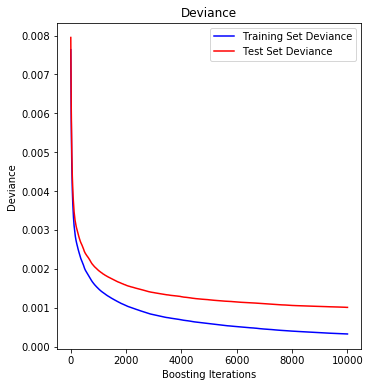

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1919)

params = {'n_estimators': 10000, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.02, 'loss': 'ls'}

clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: {}".format(mse))

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [90]:
#mse = mean_squared_error(shell_y, clf.predict(shell_X))
#print("MSE: {}".format(mse))

feat = clf.feature_importances_
pd.DataFrame({'feature': train_cols, 'importance': feat})

,feature,importance
0,salary,0.010114
1,tournament_id,0.011442
2,buyin,0.009893
3,player_id,0.006190
4,elapsed_days,0.004733
5,dk_type_dummy,0.007754
6,wins_last_30_events,0.009154
7,result_0,0.003614
8,result_1,0.001751
9,result_2,0.003870


In [60]:
#cv_params = {'max_depth': [3,4,5], 'min_child_weight': [1,3,5]}
#ind_params = {'learning_rate': [0.01, 0.02, 0.04], 'n_estimators': 700}

eval_set = [(X_test, y_test)]
xgb_regress = xgb.XGBRegressor()
xgb_regress.fit(X_train, y_train, eval_metric = ['error', 'logloss'], eval_set=eval_set, verbose = True, 
               early_stopping_rounds = 35)

[0]	validation_0-error:0.047683	validation_0-logloss:0.613943
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 35 rounds.
[1]	validation_0-error:0.047683	validation_0-logloss:0.548786
[2]	validation_0-error:0.047683	validation_0-logloss:0.494448
[3]	validation_0-error:0.047683	validation_0-logloss:0.448715
[4]	validation_0-error:0.047683	validation_0-logloss:0.409876
[5]	validation_0-error:0.047683	validation_0-logloss:0.376686
[6]	validation_0-error:0.047683	validation_0-logloss:0.348233
[7]	validation_0-error:0.047683	validation_0-logloss:0.323707
[8]	validation_0-error:0.047683	validation_0-logloss:0.30253
[9]	validation_0-error:0.047683	validation_0-logloss:0.283987
[10]	validation_0-error:0.047683	validation_0-logloss:0.267988
[11]	validation_0-error:0.047683	validation_0-logloss:0.253896
[12]	validation_0-error:0.047683	validation_0-logloss:0.241746
[13]	validation_0-error:0.0

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [118]:
mse = mean_squared_error(shell_y, xgb_regress.predict(shell_X))
print("MSE: {}".format(mse))

MSE: 0.003322156611829996


In [126]:
rbc_df['sk_predict'] = clf.predict(rbc_X).tolist()
rbc_df['xgb_predict'] = xgb_regress.predict(rbc_X).tolist()
rbc_df['tpot_predict'] = pipeline_optimizer.predict(rbc_X).tolist()

rbc_df[['buyin', 'player_name', 'salary', 'sk_predict', 'xgb_predict', 'tpot_predict']].to_csv(
        '/home/valesco/Datasets/PGA_Data/pga_temp/rbc_predict.csv', index = False)

In [123]:
config_dict = {'xgboost.XGBRegressor': {}}

pipeline_optimizer = TPOTRegressor(generations = 5, population_size = 20, cv = 4, random_state = 19,
                                   verbosity = 2, scoring = 'mean_squared_error')

pipeline_optimizer.fit(X_train, y_train)

Optimization Progress:  33%|███▎      | 40/120 [03:01<08:39,  6.50s/pipeline]

Generation 1 - Current best internal CV score: 0.001461870448273663


Optimization Progress:  50%|█████     | 60/120 [06:27<09:30,  9.50s/pipeline]

Generation 2 - Current best internal CV score: 0.001461870448273663


Optimization Progress:  67%|██████▋   | 80/120 [07:50<03:34,  5.37s/pipeline]

Generation 3 - Current best internal CV score: 0.0014287895475911655


Optimization Progress:  83%|████████▎ | 100/120 [10:22<04:37, 13.90s/pipeline]

Generation 4 - Current best internal CV score: 0.0013315665340379516


Generation 5 - Current best internal CV score: 0.0012301640796670045

Best pipeline: ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=DEFAULT, ExtraTreesRegressor__max_features=0.9, ExtraTreesRegressor__min_samples_leaf=3, ExtraTreesRegressor__min_samples_split=4)


In [23]:
tpot_predict = pipeline_optimizer.predict(shell_X)
mse = mean_squared_error(shell_y, tpot_predict)
print("MSE: {}".format(mse))

MSE: 0.003745749592781067


In [59]:
pipeline_optimizer.export('/home/valesco/Datasets/PGA_Data/pga_temp/xgboost_owernship_model.py')

In [51]:
masters_2016 = combo_df.loc[(combo_df['year'] == 2016) & (combo_df['tournament_id'] == 14.0)]
masters_index = masters_2016.index
combo_no_masters = combo_df.drop(masters_index)

In [57]:
combo_cols = list(combo_no_masters.columns)
col_remove_ls = ['player_name', 'tournament_name', 'dk_type', 'year', 'week_id', 'date']
for remove in col_remove_ls:
    combo_cols.remove(remove)

combo_process = combo_no_masters[combo_cols]
masters_2016_process = masters_2016[combo_cols]


combo_process.fillna(-999, inplace = True)
masters_2016_process.fillna(-999, inplace = True)

train_cols = combo_cols
train_cols.remove('ownership')

X = combo_process[train_cols].as_matrix().astype(np.float32)

y = combo_process['ownership'].as_matrix().astype(np.float32)

shell_X = masters_2016_process[train_cols].as_matrix().astype(np.float32)

shell_y = masters_2016_process['ownership'].as_matrix().astype(np.float32)

/home/valesco/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


MSE: 0.0009747182965892713


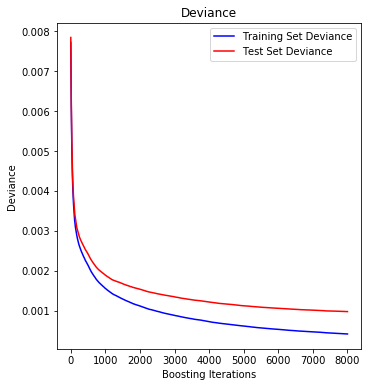

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1919)

params = {'n_estimators': 8000, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.02, 'loss': 'ls'}

clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: {}".format(mse))

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [59]:
mse = mean_squared_error(shell_y, clf.predict(shell_X))
print("MSE: {}".format(mse))

MSE: 0.0029664511706811113


In [71]:
masters_2016['sk_predict'] = clf.predict(shell_X).tolist()
masters_2016['xgb_predict'] = xgb_regress.predict(shell_X).tolist()
masters_2016['tpot_predict'] = pipeline_optimizer.predict(shell_X).tolist()
masters_2016_predict = masters_2016[['buyin', 'player_name', 'salary', 'ownership', 'xgb_predict',
                                     'tpot_predict', 'sk_predict']]
masters_2016_predict.to_csv('/home/valesco/Datasets/PGA_Data/pga_temp/masters_2016_predict.csv', index = False)

/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [68]:
pipeline_optimizer = TPOTRegressor(generations = 6, population_size = 30, cv = 4, random_state = 19,
                                   verbosity = 2, scoring = 'mean_squared_error')

pipeline_optimizer.fit(X_train, y_train)

Optimization Progress:  18%|█▊        | 80/440 [09:22<30:33,  5.09s/pipeline]  

Generation 1 - Current best internal CV score: 0.0014803643280174583


Optimization Progress:  27%|██▋       | 120/440 [14:16<13:09,  2.47s/pipeline]  

Generation 2 - Current best internal CV score: 0.0014803643280174583


Optimization Progress:  36%|███▋      | 160/440 [17:21<21:41,  4.65s/pipeline]

Generation 3 - Current best internal CV score: 0.0010283693991368636


Optimization Progress:  45%|████▌     | 200/440 [22:26<24:42,  6.18s/pipeline]  

Generation 4 - Current best internal CV score: 0.0010283693991368636


Optimization Progress:  55%|█████▍    | 240/440 [27:10<29:10,  8.75s/pipeline]

Generation 5 - Current best internal CV score: 0.0010283693991368636


Optimization Progress:  64%|██████▎   | 280/440 [34:09<30:47, 11.55s/pipeline]

Generation 6 - Current best internal CV score: 0.0010283693991368636


Optimization Progress:  73%|███████▎  | 320/440 [39:32<18:59,  9.50s/pipeline]

Generation 7 - Current best internal CV score: 0.0010283693991368636


Optimization Progress:  82%|████████▏ | 360/440 [44:10<11:19,  8.49s/pipeline]

Generation 8 - Current best internal CV score: 0.0010283693991368636


Optimization Progress:  91%|█████████ | 400/440 [51:48<08:26, 12.67s/pipeline]

Generation 9 - Current best internal CV score: 0.0010283693991368636


Generation 10 - Current best internal CV score: 0.0010283693991368636

Best pipeline: XGBRegressor(input_matrix, XGBRegressor__learning_rate=DEFAULT, XGBRegressor__max_depth=10, XGBRegressor__min_child_weight=1, XGBRegressor__subsample=0.85)


In [70]:
mse = mean_squared_error(shell_y, pipeline_optimizer.predict(shell_X))
print("MSE: {}".format(mse))

MSE: 0.003234296338632703


In [73]:
masters_2016

,buyin,ownership,player_name,tournament_name,dk_type,year,tournament_id,player_id,week_id,salary,date,elapsed_days,dk_type_dummy,wins_last_30_events,result_0,result_1,result_2,result_3,result_4,result_5,result_6,result_7,result_8,result_9,own_0,own_1,own_2,own_3,own_4,own_5,own_6,own_7,own_8,own_9,owgr_curr,owgr_avg_3,owgr_avg_10,owgr_avg_25,owgr_avg_50,num_tourny_appear,tourny_wins,tourny_cut_percent,tourny_top_20_percent,appear_0,appear_1,appear_2,appear_3,appear_4,appear_5,appear_6,appear_7,appear_8,appear_9,major_dummy,sk_predict,xgb_predict,tpot_predict
23747,20.0,0.26,Jason Day,Masters,GPP,2016,14.0,28089,2016_014_28089,11600.0,2016-04-10,359,0,5.0,1.0,23.0,11.0,101.0,10.0,10.0,1.0,12.0,1.0,12.0,0.16,0.09,0.17,0.09,0.04,-999.00,-999.00,-999.00,-999.00,-999.00,1.0,1.333333,2.2,1.96,3.860000,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.178989,0.168534,0.209018
23748,20.0,0.22,Rickie Fowler,Masters,GPP,2016,14.0,32102,2016_014_32102,10900.0,2016-04-10,359,0,4.0,10.0,4.0,8.0,11.0,6.0,2.0,2.0,72.0,2.0,14.0,0.20,0.12,0.06,0.27,0.28,0.22,-999.00,-999.00,-999.00,-999.00,5.0,5.000000,4.7,5.24,6.440000,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.128560,0.124587,0.135875
23749,20.0,0.22,Ryan Moore,Masters,GPP,2016,14.0,26596,2016_014_26596,6800.0,2016-04-10,359,0,2.0,74.0,3.0,10.0,136.0,11.0,10.0,43.0,10.0,28.0,96.0,0.15,0.10,0.13,0.13,0.13,0.12,0.05,0.04,0.05,0.12,40.0,42.000000,55.1,57.52,48.520000,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.057862,0.071986,0.045777
23750,20.0,0.20,Justin Rose,Masters,GPP,2016,14.0,22405,2016_014_22405,9900.0,2016-04-10,359,0,3.0,9.0,17.0,16.0,6.0,72.0,6.0,2.0,13.0,75.0,16.0,0.19,0.23,0.23,0.13,0.16,0.12,0.05,0.03,-999.00,-999.00,9.0,8.333333,7.6,6.88,6.620000,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.137832,0.148270,0.173835
23751,20.0,0.19,Zach Johnson,Masters,GPP,2016,14.0,24024,2016_014_24024,7600.0,2016-04-10,359,0,2.0,5.0,47.0,92.0,14.0,102.0,9.0,21.0,75.0,8.0,13.0,0.20,0.31,0.19,0.15,0.05,0.02,-999.00,-999.00,-999.00,-999.00,16.0,15.666667,16.4,13.44,15.780000,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.110204,0.075443,0.074806
23752,20.0,0.18,Charley Hoffman,Masters,GPP,2016,14.0,12716,2016_014_12716,6400.0,2016-04-10,359,0,2.0,33.0,11.0,17.0,63.0,51.0,43.0,84.0,1.0,96.0,22.0,0.06,0.05,0.05,0.03,0.04,0.06,0.02,0.01,0.10,0.11,59.0,58.333333,56.4,51.04,47.120000,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.071836,0.065342,0.033664
23753,20.0,0.18,Patrick Reed,Masters,GPP,2016,14.0,34360,2016_014_34360,8300.0,2016-04-10,359,0,3.0,10.0,7.0,52.0,92.0,6.0,NaN,56.0,2.0,NaN,10.0,0.13,0.10,0.03,0.24,0.15,0.15,-999.00,-999.00,-999.00,-999.00,10.0,10.000000,9.6,11.60,14.200000,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.099089,0.095260,0.103583
23754,20.0,0.18,Kevin Na,Masters,GPP,2016,14.0,25396,2016_014_25396,6900.0,2016-04-10,359,0,0.0,22.0,35.0,126.0,120.0,24.0,3.0,28.0,NaN,3.0,2.0,0.17,0.17,0.20,0.21,0.20,0.23,0.22,0.24,0.20,0.32,27.0,27.333333,25.4,23.28,25.460000,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.076286,0.069733,0.066005
23755,20.0,0.18,Dustin Johnson,Masters,GPP,2016,14.0,30925,2016_014_30925,10200.0,2016-04-10,359,0,2.0,3.0,14.0,4.0,41.0,18.0,10.0,NaN,5.0,7.0,44.0,0.15,0.15,0.11,0.22,0.24,-999.00,-999.00,-999.00,-999.00,-999.00,8.0,8.666667,8.4,8.16,7.660000,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1,0.172541,0.142674,0.176535
23756,20.0,0.18,Smylie Kaufman,Masters,GPP,2016,14.0,46440,2016_014_46440,6000.0,2016-04-10,359,0,1.0,12.0,8.0,37.0,126.0,103.0,25.0,14.0,15.0,33.0,54.0,0.16,0.26,0.17,0.05,0.08,0.06,0.05,0.18,0.49,-

In [85]:
player_info['player_name'] = player_info['first_name'] + ' ' + player_info['last_name']
player_names = player_info['player_name'].values

In [90]:
def fuzz_match(x):
    matched = process.extractOne(x, player_names)
    if matched[1] > 89:
        return player_info['player_id'].loc[player_info['player_name'] == matched[0]].values[0]
    else:
        return np.nan
    
masters_2017['player_id'] = masters_2017['player_name'].apply(lambda x: fuzz_match(x))
masters_2017.dropna(inplace = True)

In [93]:
player_info['player_id'] = player_info['player_id'].apply(lambda x: float(x))

In [176]:
shell_df = shell_df.merge(player_info[['player_id', 'height_inches', 'weight', 'birth_date', 'turned_pro_stamp']],
                 on = 'player_id', how = 'left')

In [119]:
#masters_2017['age_in_days'] = masters_2017['birth_date'].apply(lambda x: elapsed(x))
#masters_2017['days_pro'] = masters_2017['turned_pro_stamp'].apply(lambda x: elapsed(x))
#masters_2017['dk_type'] = 'GPP'

masters_2017['player_id'].dtype

dtype('float64')

In [82]:
#combo_df = combo_df.append(shell_df)

rbc_df = rbc_df.merge(player_info[['player_id', 'height_inches', 'weight', 'birth_date', 'turned_pro_stamp']],
                 on = 'player_id', how = 'left')

rbc_df['age_in_days'] = rbc_df['birth_date'].apply(lambda x: elapsed(x))
rbc_df['days_pro'] = rbc_df['turned_pro_stamp'].apply(lambda x: elapsed(x))

In [78]:
#masters_2017['elapsed_days'] = masters_2017['date'].apply(lambda x: elapsed(x))
#masters_2017['dk_type_dummy'] = masters_2017['dk_type'].apply(lambda x: tourny_dummy(x))
#masters_2017['buyin'] = masters_2017['buyin'].apply(lambda x: float(x.replace(',','').split('.')[0]))
#masters_2017['owgr'] = masters_2017.apply(map_owgr, axis = 1)
#masters_2017['recent_ownership'] = masters_2017.apply(recent_ownership, axis = 1)
#masters_2017['prev_appear'] = masters_2017.apply(prev_appear, axis = 1)
#masters_2017['recent_results'] = masters_2017.apply(recent_results, axis = 1)


rbc_df[['wins_last_30_events', 'result_0', 'result_1', 'result_2', 'result_3', 'result_4', 'result_5',
         'result_6', 'result_7', 'result_8', 'result_9']] = rbc_df['recent_results'].apply(pd.Series)

rbc_df[['own_0', 'own_1', 'own_2', 'own_3', 'own_4', 'own_5', 'own_6', 'own_7', 'own_8',
         'own_9']] = rbc_df['recent_ownership'].apply(pd.Series)

rbc_df[['owgr_curr', 'owgr_avg_3', 'owgr_avg_10', 'owgr_avg_25', 'owgr_avg_50']] = rbc_df['owgr'].apply(pd.Series)

rbc_df[['num_tourny_appear', 'tourny_wins', 'tourny_cut_percent', 'tourny_top_20_percent', 'appear_0',
         'appear_1', 'appear_2', 'appear_3', 'appear_4', 'appear_5', 'appear_6', 'appear_7', 'appear_8', 
         'appear_9']] = rbc_df['prev_appear'].apply(pd.Series)

rbc_df.drop(['recent_results', 'recent_ownership', 'prev_appear', 'owgr'], axis = 1, inplace = True)

In [160]:
result_ls = []

for index, df in masters_2017.iterrows():
    try:
        player_id = df['player_id']
        date_cutoff = pd.to_datetime(df['date'])
        temp_df = player_results.loc[(player_results['player_id'] == player_id) & 
                                     (pd.to_datetime(player_results['tournament_start_date']) < date_cutoff)]

        temp_df.sort_values(by = 'tournament_start_date', ascending = False, inplace = True)
        
        recent_wins = 0
        
        for i in range(52):
            if i < 10: 
                try:
                    globals()['results_' + str(i)] = temp_df['final_rank'].iloc[i]
                except:
                    globals()['results_' + str(i)] = -999
            try:
                if temp_df['final_rank'].iloc[i] == 1:
                    recent_wins += 1
            except:
                pass

        result_ls.append((recent_wins, results_0, results_1, results_2, results_3, results_4, results_5, results_6, 
              results_7, results_8, results_9))
    except:
        result_ls.append((-999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999))

/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [163]:
combo_df.to_csv('/home/valesco/Datasets/PGA_Data/pga_temp/full_combo_df.csv', index = False, sep = ';')
masters_2017.to_csv('/home/valesco/Datasets/PGA_Data/pga_temp/masters_2017.csv', index = False, sep = ';')

In [192]:
masters_2017['major_dummy'] = 1
masters_2017['ownership'] = np.nan
combo_df.rename(columns = {'tournament': 'tournament'}, inplace = True)
combo_cols = list(combo_df.columns)
col_remove_ls = ['player_name', 'tournament_name', 'dk_type', 'year', 'week_id', 'date', 'birth_date', 
                'turned_pro_stamp']
for remove in col_remove_ls:
    combo_cols.remove(remove)

combo_process = combo_df[combo_cols]
masters_process = masters_2017[combo_cols]

In [216]:
#combo_df['type'] = combo_df['type'].apply(lambda x: tourny_dummy(x))
#masters_2017['type'] = masters_2017['type'].apply(lambda x: tourny_dummy(x))
combo_cols = list(combo_df.columns)
col_remove_ls = ['player_name', 'tournament_name', 'dk_type', 'year', 'week_id', 'date', 'birth_date', 
                'turned_pro_stamp', 'player_id']
for remove in col_remove_ls:
    combo_cols.remove(remove)


combo_process_nopid = combo_df[combo_cols]
masters_2017_process_nopid = masters_2017[combo_cols]


combo_process_nopid.fillna(-999, inplace = True)
masters_2017_process_nopid.fillna(-999, inplace = True)

train_cols = combo_cols
train_cols.remove('ownership')

X = combo_process_nopid[train_cols].as_matrix().astype(np.float32)

y = combo_process_nopid['ownership'].as_matrix().astype(np.float32)

X_nopid = masters_2017_process_nopid[train_cols].as_matrix().astype(np.float32)

#shell_y = masters_2017_process_nopid['ownership'].as_matrix().astype(np.float32)

/home/valesco/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


MSE: 0.0009775017343854472


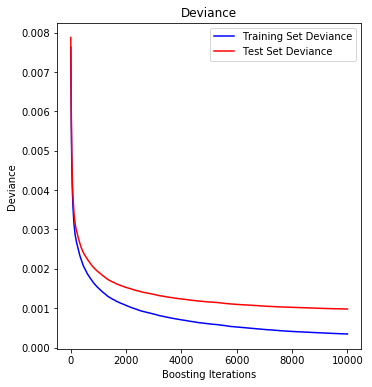

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1919)

params = {'n_estimators': 10000, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.02, 'loss': 'ls'}

clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: {}".format(mse))

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [218]:
feat = clf.feature_importances_
pd.DataFrame({'feature': train_cols, 'importance': feat})

,feature,importance
0,age_in_days,0.065679
1,appear_0,0.010366
2,appear_1,0.011792
3,appear_2,0.011001
4,appear_3,0.008912
5,appear_4,0.004827
6,appear_5,0.007307
7,appear_6,0.007056
8,appear_7,0.003199
9,appear_8,0.001386


In [215]:
masters_2017['sklearn_predict'] = clf.predict(masters_X)
masters_2017['tpot_predict'] = masters_tpot.predict(masters_X)
masters_2017['xgb_predict'] = xgb_regress.predict(masters_X)

masters_2017.to_csv('/home/valesco/Datasets/PGA_Data/pga_temp/masters_predict.csv', index = False)

In [220]:
masters_tpot = TPOTRegressor(generations = 5, population_size = 30, cv = 4, random_state = 19,
                                   verbosity = 2, scoring = 'mean_squared_error')

masters_tpot.fit(X_train, y_train)

Optimization Progress:  33%|███▎      | 60/180 [04:37<12:56,  6.47s/pipeline]

Generation 1 - Current best internal CV score: 0.0015123424301868027


Optimization Progress:  50%|█████     | 90/180 [07:49<12:56,  8.63s/pipeline]

Generation 2 - Current best internal CV score: 0.0013042595174248342


Optimization Progress:  67%|██████▋   | 120/180 [09:58<06:38,  6.64s/pipeline]

Generation 3 - Current best internal CV score: 0.001183509681141004


Optimization Progress:  83%|████████▎ | 150/180 [11:38<02:15,  4.53s/pipeline]

Generation 4 - Current best internal CV score: 0.001183509681141004


Generation 5 - Current best internal CV score: 0.0010003338975366205

Best pipeline: XGBRegressor(input_matrix, XGBRegressor__learning_rate=DEFAULT, XGBRegressor__max_depth=9, XGBRegressor__min_child_weight=1, XGBRegressor__subsample=0.65)


In [124]:
#masters_2017_process['elasped_days'] = 0 
#masters_X = masters_2017_process[train_cols].as_matrix().astype(np.float32)

eval_set = [(X_test, y_test)]
xgb_regress = xgb.XGBRegressor(n_estimators = 1000, max_depth = 3, learning_rate = 0.03)
xgb_regress.fit(X_train, y_train, eval_metric = 'rmse', eval_set=eval_set, verbose = True, 
               early_stopping_rounds = 50)

[0]	validation_0-rmse:0.446545
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.433457
[2]	validation_0-rmse:0.420768
[3]	validation_0-rmse:0.408479
[4]	validation_0-rmse:0.396561
[5]	validation_0-rmse:0.385011
[6]	validation_0-rmse:0.373821
[7]	validation_0-rmse:0.362977
[8]	validation_0-rmse:0.352469
[9]	validation_0-rmse:0.34229
[10]	validation_0-rmse:0.332425
[11]	validation_0-rmse:0.322867
[12]	validation_0-rmse:0.313609
[13]	validation_0-rmse:0.304642
[14]	validation_0-rmse:0.29596
[15]	validation_0-rmse:0.287544
[16]	validation_0-rmse:0.279391
[17]	validation_0-rmse:0.271498
[18]	validation_0-rmse:0.263852
[19]	validation_0-rmse:0.256451
[20]	validation_0-rmse:0.249256
[21]	validation_0-rmse:0.242319
[22]	validation_0-rmse:0.235606
[23]	validation_0-rmse:0.229077
[24]	validation_0-rmse:0.222792
[25]	validation_0-rmse:0.216672
[26]	validation_0-rmse:0.210789
[27]	validation_0-rmse:0.205055
[28]	validation_0-rmse:0.199544
[29]	validation_0-r

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.03, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [5]:
combo_df.sort_values(by = 'date', ascending = False)

,buyin,ownership,player_name,tournament_name,dk_type,year,tournament_id,player_id,week_id,salary,date,elapsed_days,dk_type_dummy,wins_last_30_events,result_0,result_1,result_2,result_3,result_4,result_5,result_6,result_7,result_8,result_9,own_0,own_1,own_2,own_3,own_4,own_5,own_6,own_7,own_8,own_9,owgr_curr,owgr_avg_3,owgr_avg_10,owgr_avg_25,owgr_avg_50,num_tourny_appear,tourny_wins,tourny_cut_percent,tourny_top_20_percent,appear_0,appear_1,appear_2,appear_3,appear_4,appear_5,appear_6,appear_7,appear_8,appear_9
15384,1,0.1830,Seamus Power,Puerto Rico Open,GPP,2017,483.0,46459,2017_483_46459,7300.0,2017-03-26,9,0,0.0,141.0,43.0,93.0,147.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0000,0.0060,0.0000,0.0045,0.0043,0.0038,0.0072,0.0055,0.0039,0.0059,-999.0,-999.000000,-999.0,-999.000000,-999.000000,0.0,0.0,-999.000000,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
14193,333,0.0000,Jay McLuen,Puerto Rico Open,GPP,2017,483.0,27171,2017_483_27171,5900.0,2017-03-26,9,0,2.0,NaN,117.0,16.0,99.0,129.0,32.0,81.0,21.0,NaN,3.0,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,1.0,0.0,0.000000,0.000000,NaN,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
14182,333,0.0000,Sebastian Munoz,Puerto Rico Open,GPP,2017,483.0,35469,2017_483_35469,6000.0,2017-03-26,9,0,0.0,95.0,82.0,135.0,149.0,84.0,99.0,55.0,5.0,70.0,23.0,0.0002,0.0000,0.0000,0.0000,0.0002,0.0000,0.0006,0.0000,0.0001,0.0003,-999.0,-999.000000,-999.0,-999.000000,-999.000000,1.0,0.0,1.000000,0.000000,56.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
14183,333,0.0000,Wade Binfield,Puerto Rico Open,GPP,2017,483.0,96098,2017_483_96098,6000.0,2017-03-26,9,0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,300.0,292.000000,282.4,281.840000,282.285714,0.0,0.0,-999.000000,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
14184,333,0.0000,Robert Calvesbert,Puerto Rico Open,GPP,2017,483.0,10885,2017_483_10885,6000.0,2017-03-26,9,0,0.0,68.0,93.0,100.0,NaN,63.0,91.0,74.0,134.0,144.0,114.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,300.0,298.333333,285.1,269.680000,213.740000,3.0,0.0,0.000000,0.000000,111.0,110.0,86.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
14185,333,0.0148,Michael Bradley,Puerto Rico Open,GPP,2017,483.0,1116,2017_483_1116,5900.0,2017-03-26,9,0,0.0,42.0,52.0,123.0,58.0,128.0,26.0,147.0,50.0,88.0,116.0,0.0000,0.0000,0.0000,0.0200,0.0300,0.0400,-999.0000,-999.0000,-999.0000,-999.0000,296.0,291.333333,283.8,276.080000,260.140000,8.0,2.0,0.875000,0.375000,26.0,27.0,103.0,49.0,42.0,1.0,15.0,1.0,-999.0,-999.0
14186,333,0.0000,Ben Curtis,Puerto Rico Open,GPP,2017,483.0,22621,2017_483_22621,5900.0,2017-03-26,9,0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0000,0.0000,0.0024,0.0035,0.0000,0.0026,0.0023,0.0039,0.0002,0.0037,295.0,293.666667,287.4,275.840000,219.780000,0.0,0.0,-999.000000,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
14187,333,0.0000,William Lunde,Puerto Rico Open,GPP,2017,483.0,23548,2017_483_23548,5900.0,2017-03-26,9,0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0000,0.0000,0.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,290.0,284.000000,282.6,281.480000,261.440000,0.0,0.0,-999.000000,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
14188,333,0.0000,Rich Berberian,Puerto Rico Open,GPP,2017,483.0,47986,2017_483_47986,5900.0,2017-03-26,9,0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,

In [47]:
new_df = combo_df.append(shell_df)

In [48]:
new_df = new_df.append(masters_df)

In [51]:
new_df.drop('end_date', inplace = True, axis = 1)

In [46]:
masters_df.rename(columns = {'tournament': 'tournament_name', 'player': 'player_name', 'type': 'dk_type'},
               inplace = True)

In [53]:
combo_df = new_df

In [63]:
def replace_buyin(x):
    if type(x) == float:
        return x
    else:
        return float(x.replace(',',''))

combo_process['buyin'] = combo_process['buyin'].apply(lambda x: replace_buyin(x))

/home/valesco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [80]:
rbc_df['elapsed_days'] = 0
rbc_df

,player_name,salary,tournament_name,tournament_id,buyin,player_id,date,elapsed_days,dk_type,dk_type_dummy,wins_last_30_events,result_0,result_1,result_2,result_3,result_4,result_5,result_6,result_7,result_8,result_9,own_0,own_1,own_2,own_3,own_4,own_5,own_6,own_7,own_8,own_9,owgr_curr,owgr_avg_3,owgr_avg_10,owgr_avg_25,owgr_avg_50,num_tourny_appear,tourny_wins,tourny_cut_percent,tourny_top_20_percent,appear_0,appear_1,appear_2,appear_3,appear_4,appear_5,appear_6,appear_7,appear_8,appear_9
0,Matt Kuchar,11500,RBC Heritage,12,3,23108.0,2017-04-13,0,GPP,0,0.0,22.0,20.0,22.0,89.0,9.0,129.0,71.0,15.0,4.0,46.0,0.1145,0.1237,0.0200,0.0694,0.0820,0.0558,0.1287,0.0986,0.1017,0.0983,21.0,20.333333,20.4,19.84,19.880,5.0,1.0,1.000000,0.600000,9.0,5.0,1.0,35.0,44.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,Russell Henley,10700,RBC Heritage,12,3,34098.0,2017-04-13,0,GPP,0,0.0,45.0,9.0,43.0,16.0,102.0,13.0,10.0,24.0,14.0,71.0,0.0937,0.0996,0.2400,0.1111,0.0963,0.1331,0.1190,0.1091,0.1310,0.1166,117.0,116.333333,127.6,120.68,106.140,4.0,0.0,0.500000,0.250000,23.0,77.0,125.0,6.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,Brandt Snedeker,10500,RBC Heritage,12,3,27649.0,2017-04-13,0,GPP,0,1.0,28.0,7.0,83.0,4.0,9.0,98.0,14.0,45.0,17.0,13.0,0.1516,0.1652,0.1467,0.1806,0.0731,0.1457,0.1489,0.1336,0.1191,0.1595,22.0,23.000000,24.5,24.80,22.480,5.0,0.0,0.800000,0.200000,99.0,26.0,74.0,59.0,17.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,Branden Grace,10000,RBC Heritage,12,3,29974.0,2017-04-13,0,GPP,0,4.0,91.0,32.0,NaN,22.0,13.0,32.0,33.0,32.0,41.0,111.0,0.0127,0.0128,0.0000,0.0000,0.0160,0.0078,0.0125,0.0108,0.0011,0.0087,20.0,19.333333,17.9,16.64,14.140,2.0,1.0,1.000000,1.000000,1.0,7.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,Kevin Kisner,9700,RBC Heritage,12,3,29478.0,2017-04-13,0,GPP,0,1.0,2.0,11.0,48.0,10.0,25.0,4.0,110.0,26.0,26.0,39.0,0.1777,0.1792,0.1933,0.1667,0.0588,0.1385,0.0510,0.1678,0.1996,0.1910,36.0,40.000000,44.0,43.20,35.240,3.0,0.0,1.000000,0.333333,69.0,2.0,38.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
5,Martin Kaymer,9500,RBC Heritage,12,3,27408.0,2017-04-13,0,GPP,0,2.0,23.0,23.0,4.0,7.0,36.0,13.0,NaN,37.0,NaN,NaN,0.0668,0.0419,0.0556,0.1961,0.0612,0.1677,0.0605,0.0658,0.0261,0.0618,44.0,44.666667,46.8,49.00,51.060,2.0,0.0,1.000000,0.000000,23.0,66.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
6,Tyrrell Hatton,9300,RBC Heritage,12,3,34363.0,2017-04-13,0,GPP,0,0.0,4.0,10.0,4.0,82.0,NaN,10.0,5.0,2.0,NaN,NaN,0.2813,0.2938,0.2639,0.0000,0.2638,0.0002,0.2752,0.2474,0.3627,0.2798,15.0,15.000000,18.1,26.12,55.220,0.0,0.0,-999.000000,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
7,Bill Haas,9100,RBC Heritage,12,3,24924.0,2017-04-13,0,GPP,0,1.0,41.0,32.0,11.0,17.0,13.0,13.0,20.0,32.0,67.0,100.0,0.1114,0.1370,0.1389,0.0463,0.1319,0.0620,0.1199,0.1112,0.2355,0.1324,39.0,43.000000,42.6,41.52,37.040,5.0,0.0,0.600000,0.200000,14.0,31.0,NaN,24.0,95.0,-999.0,-999.0,-999.0,-999.0,-999.0
8,Adam Hadwin,8800,RBC Heritage,12,3,33399.0,2017-04-13,0,GPP,0,1.0,6.0,1.0,34.0,39.0,12.0,49.0,2.0,10.0,27.0,21.0,0.2301,0.2311,0.3067,0.1806,0.2248,0.1301,0.2299,0.2293,0.3029,0.2301,46.0,47.000000,87.0,149.56,165.340,2.0,0.0,0.500000,0.000000,30.0,87.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
9,Charley Hoffman,8700,RBC Heritage,12,3,12716.0,2017-04-13,0,GPP,0,2.0,2.0,109.0,4.0,100.0,24.0,54.0,123.0,17.0,74.0,131.0,0.0405,0.0460,0.0267,0.0417,0.1319,0.0528,0.2173,0.0472,0.0712,0.0426,52.0,57.000000,65.5,62.20,52.280,5.0,0.0,1.000000,0.600000,14.0,64.0,38.0,6.0,8.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [121]:
clf.predict(rbc_X)

array([  1.64098689e-01,   1.49894653e-01,   1.53472815e-01,
         9.59819573e-02,   2.56525179e-01,   1.29417673e-01,
         1.73106285e-01,   1.51543703e-01,   1.83345123e-01,
         8.80629686e-02,   1.12903553e-01,   8.48367879e-02,
         6.26583493e-02,   1.37029990e-01,   7.13499155e-02,
         6.89412724e-02,   8.71700567e-02,   1.63482962e-01,
         1.13704237e-01,   7.43344244e-02,   1.57267351e-01,
         8.45670310e-02,   1.12215833e-01,   1.11785156e-01,
         5.12271231e-02,   2.89415377e-02,   3.67584729e-02,
         1.07604122e-02,   5.70506825e-02,   1.43474389e-02,
         1.38467299e-01,   1.44315371e-01,   4.88816636e-02,
         2.11412515e-02,   4.05676055e-02,   3.47158034e-02,
         6.32594508e-02,   5.48804077e-02,   2.59652160e-02,
         3.02892115e-02,   3.57801619e-02,   2.80982094e-02,
         9.84697834e-02,   5.28823134e-03,   1.29261675e-02,
         1.65527789e-02,   1.22959463e-02,   1.31926971e-02,
        -4.39289897e-03,

In [99]:
col_ls = rbc_process.columns
rbc_process[col_ls]

,salary,tournament_id,buyin,player_id,elapsed_days,dk_type_dummy,wins_last_30_events,result_0,result_1,result_2,result_3,result_4,result_5,result_6,result_7,result_8,result_9,own_0,own_1,own_2,own_3,own_4,own_5,own_6,own_7,own_8,own_9,owgr_curr,owgr_avg_3,owgr_avg_10,owgr_avg_25,owgr_avg_50,num_tourny_appear,tourny_wins,tourny_cut_percent,tourny_top_20_percent,appear_0,appear_1,appear_2,appear_3,appear_4,appear_5,appear_6,appear_7,appear_8,appear_9,height_inches,weight,age_in_days,days_pro
0,11500,12,3,23108.0,0,0,0.0,22.0,20.0,22.0,89.0,9.0,129.0,71.0,15.0,4.0,46.0,0.1145,0.1237,0.0200,0.0694,0.0820,0.0558,0.1287,0.0986,0.1017,0.0983,21.0,20.333333,20.4,19.84,19.880,5.0,1.0,1.000000,0.600000,9.0,5.0,1.0,35.0,44.0,-999.0,-999.0,-999.0,-999.0,-999.0,76.0,195.0,14174,6310
1,10700,12,3,34098.0,0,0,0.0,45.0,9.0,43.0,16.0,102.0,13.0,10.0,24.0,14.0,71.0,0.0937,0.0996,0.2400,0.1111,0.0963,0.1331,0.1190,0.1091,0.1310,0.1166,117.0,116.333333,127.6,120.68,106.140,4.0,0.0,0.500000,0.250000,23.0,77.0,125.0,6.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,72.0,180.0,10226,2292
2,10500,12,3,27649.0,0,0,1.0,28.0,7.0,83.0,4.0,9.0,98.0,14.0,45.0,17.0,13.0,0.1516,0.1652,0.1467,0.1806,0.0731,0.1457,0.1489,0.1336,0.1191,0.1595,22.0,23.000000,24.5,24.80,22.480,5.0,0.0,0.800000,0.200000,99.0,26.0,74.0,59.0,17.0,-999.0,-999.0,-999.0,-999.0,-999.0,73.0,185.0,13273,4849
3,10000,12,3,29974.0,0,0,4.0,91.0,32.0,-999.0,22.0,13.0,32.0,33.0,32.0,41.0,111.0,0.0127,0.0128,0.0000,0.0000,0.0160,0.0078,0.0125,0.0108,0.0011,0.0087,20.0,19.333333,17.9,16.64,14.140,2.0,1.0,1.000000,1.000000,1.0,7.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,70.0,171.0,10553,3753
4,9700,12,3,29478.0,0,0,1.0,2.0,11.0,48.0,10.0,25.0,4.0,110.0,26.0,26.0,39.0,0.1777,0.1792,0.1933,0.1667,0.0588,0.1385,0.0510,0.1678,0.1996,0.1910,36.0,40.000000,44.0,43.20,35.240,3.0,0.0,1.000000,0.333333,69.0,2.0,38.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,70.0,165.0,12109,4118
5,9500,12,3,27408.0,0,0,2.0,23.0,23.0,4.0,7.0,36.0,13.0,-999.0,37.0,-999.0,-999.0,0.0668,0.0419,0.0556,0.1961,0.0612,0.1677,0.0605,0.0658,0.0261,0.0618,44.0,44.666667,46.8,49.00,51.060,2.0,0.0,1.000000,0.000000,23.0,66.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,72.0,165.0,11792,4483
6,9300,12,3,34363.0,0,0,0.0,4.0,10.0,4.0,82.0,-999.0,10.0,5.0,2.0,-999.0,-999.0,0.2813,0.2938,0.2639,0.0000,0.2638,0.0002,0.2752,0.2474,0.3627,0.2798,15.0,15.000000,18.1,26.12,55.220,0.0,0.0,-999.000000,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,69.0,161.0,9311,2292
7,9100,12,3,24924.0,0,0,1.0,41.0,32.0,11.0,17.0,13.0,13.0,20.0,32.0,67.0,100.0,0.1114,0.1370,0.1389,0.0463,0.1319,0.0620,0.1199,0.1112,0.2355,0.1324,39.0,43.000000,42.6,41.52,37.040,5.0,0.0,0.600000,0.200000,14.0,31.0,-999.0,24.0,95.0,-999.0,-999.0,-999.0,-999.0,-999.0,74.0,185.0,12741,4849
8,8800,12,3,33399.0,0,0,1.0,6.0,1.0,34.0,39.0,12.0,49.0,2.0,10.0,27.0,21.0,0.2301,0.2311,0.3067,0.1806,0.2248,0.1301,0.2299,0.2293,0.3029,0.2301,46.0,47.000000,87.0,149.56,165.340,2.0,0.0,0.500000,0.000000,30.0,87.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,68.0,165.0,10753,3022
9,8700,12,3,12716.0,0,0,2.0,2.0,109.0,4.0,100.0,24.0,54.0,123.0,17.0,74.0,131.0,0.0405,0.0460,0.0267,0.0417,0.1319,0.0528,0.2173,0.0472,0.0712,0.0426,52.0,57.000000,65.5,62.20,52.280,5.0,0.0,1.000000,0.600000,14.0,64.0,38.0,6.0,8.0,-999.0,-999.0,-999.0,-999.0,-999.0,72.0,200.0,14715,6310


In [100]:
combo_process[col_ls]

,salary,tournament_id,buyin,player_id,elapsed_days,dk_type_dummy,wins_last_30_events,result_0,result_1,result_2,result_3,result_4,result_5,result_6,result_7,result_8,result_9,own_0,own_1,own_2,own_3,own_4,own_5,own_6,own_7,own_8,own_9,owgr_curr,owgr_avg_3,owgr_avg_10,owgr_avg_25,owgr_avg_50,num_tourny_appear,tourny_wins,tourny_cut_percent,tourny_top_20_percent,appear_0,appear_1,appear_2,appear_3,appear_4,appear_5,appear_6,appear_7,appear_8,appear_9,height_inches,weight,age_in_days,days_pro
0,11900.0,475.0,5300.00,33448.0,23,0,4.0,93.0,5.0,71.0,39.0,76.0,1.0,1.0,1.0,8.0,6.0,0.0949,0.0984,0.1163,0.1290,0.1082,0.0696,0.1081,0.1058,0.0631,0.1171,7.0,7.666667,9.7,20.120000,27.020000,3.0,0.0,0.666667,0.666667,93.0,18.0,10.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,70.0,145.0,8748,1561
1,11700.0,475.0,5300.00,21528.0,23,0,3.0,7.0,-999.0,41.0,-999.0,13.0,-999.0,-999.0,131.0,86.0,2.0,0.2100,0.2000,0.1800,0.1600,0.1800,0.1600,0.1300,0.1300,0.1500,0.2800,6.0,5.000000,4.2,4.400000,5.100000,3.0,0.0,1.000000,1.000000,7.0,11.0,4.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,74.0,190.0,14981,6675
2,10200.0,475.0,5300.00,23108.0,23,0,0.0,22.0,20.0,22.0,89.0,9.0,129.0,71.0,15.0,4.0,46.0,0.1376,0.1284,0.1395,0.1380,0.1915,0.1295,0.1377,0.1330,0.1849,0.1464,20.0,20.000000,20.4,19.440000,20.380000,4.0,0.0,1.000000,0.250000,22.0,11.0,33.0,38.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,76.0,195.0,14174,6310
3,10100.0,475.0,5300.00,40026.0,23,0,1.0,70.0,16.0,96.0,7.0,110.0,45.0,14.0,51.0,15.0,10.0,0.0465,0.0119,0.0122,0.0228,0.0197,0.0287,0.0161,0.0251,0.0230,0.0170,36.0,34.666667,33.5,33.920000,37.960000,3.0,0.0,0.333333,0.333333,70.0,11.0,72.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,73.0,175.0,8770,1561
4,9700.0,475.0,5300.00,34360.0,23,0,2.0,38.0,61.0,59.0,23.0,68.0,12.0,6.0,51.0,24.0,13.0,0.1161,0.1089,0.1173,0.1456,0.0425,0.1168,0.1086,0.0954,0.0566,0.0945,12.0,11.666667,9.8,8.560000,10.360000,3.0,0.0,1.000000,0.666667,38.0,7.0,2.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,72.0,200.0,9746,2292
5,9400.0,475.0,5300.00,21961.0,23,0,0.0,49.0,52.0,15.0,2.0,12.0,8.0,13.0,7.0,15.0,39.0,0.2918,0.2454,0.4000,0.2513,0.4795,0.2848,0.2878,0.2805,0.4642,0.2701,65.0,64.000000,78.4,91.440000,90.940000,4.0,0.0,1.000000,0.750000,49.0,5.0,10.0,14.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,71.0,155.0,13810,6310
6,9200.0,475.0,5300.00,24924.0,23,0,1.0,41.0,32.0,11.0,17.0,13.0,13.0,20.0,32.0,67.0,100.0,0.1577,0.1819,0.2174,0.2093,0.1659,0.2628,0.1782,0.2269,0.1574,0.2488,44.0,43.000000,42.1,40.840000,36.300000,3.0,0.0,1.000000,0.666667,41.0,2.0,14.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,74.0,185.0,12741,4849
7,9000.0,475.0,5300.00,26596.0,23,0,2.0,18.0,28.0,83.0,61.0,3.0,15.0,17.0,2.0,64.0,8.0,0.0197,0.0150,0.0104,0.0272,0.0295,0.0233,0.0000,0.0074,0.0273,0.0181,37.0,33.666667,31.4,33.000000,41.480000,3.0,0.0,1.000000,1.000000,18.0,3.0,5.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,69.0,170.0,12546,4483
8,8900.0,475.0,5300.00,31323.0,23,0,0.0,58.0,38.0,2.0,5.0,100.0,20.0,6.0,2.0,56.0,10.0,0.1927,0.1918,0.2174,0.1628,0.1549,0.1680,0.1828,0.1906,0.2114,0.2068,34.0,35.000000,41.4,46.120000,56.200000,4.0,0.0,0.750000,0.250000,58.0,42.0,103.0,8.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,73.0,195.0,12013,3753
9,8800.0,475.0,5300.00,26331.0,23,0,1.0,6.0,38.0,121.0,10.0,4.0,70.0,53.0,7.0,11.0,25.0,0.0161,0.0161,0.0217,0.0145,0.0187,0.0106,0.0152,0.0123,0.0167,0.0061,28.0,27.333333,25.4,25.320000,23.700000,2.0,1.0,1.000000,1.000000,6.0,1.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,71.0,160.0,11911,5579


In [116]:
rbc_process = rbc_process[combo_cols]

In [114]:
combo_cols

['appear_0',
 'appear_1',
 'appear_2',
 'appear_3',
 'appear_4',
 'appear_5',
 'appear_6',
 'appear_7',
 'appear_8',
 'appear_9',
 'buyin',
 'dk_type_dummy',
 'elapsed_days',
 'num_tourny_appear',
 'owgr_avg_10',
 'owgr_avg_25',
 'owgr_avg_3',
 'owgr_avg_50',
 'owgr_curr',
 'own_0',
 'own_1',
 'own_2',
 'own_3',
 'own_4',
 'own_5',
 'own_6',
 'own_7',
 'own_8',
 'own_9',
 'player_id',
 'result_0',
 'result_1',
 'result_2',
 'result_3',
 'result_4',
 'result_5',
 'result_6',
 'result_7',
 'result_8',
 'result_9',
 'salary',
 'tournament_id',
 'tourny_cut_percent',
 'tourny_top_20_percent',
 'tourny_wins',
 'wins_last_30_events',
 'height_inches',
 'weight',
 'age_in_days',
 'days_pro']

In [134]:
assert rbc_df['buyin'].dtype == int or rbc_df.buyin.dtype == float